In [1]:
from utils import get_path, load_data

TRAIN, TEST = load_data(
    'mimic3-mimic3', 'mimic3-mimic3_reference.csv',
    {
        'train': {'mimic3_A': 'mimic3_train_A', 'mimic3_B': 'mimic3_train_B'},
        'test': {'mimic3_A': 'mimic3_test_A', 'mimic3_B': 'mimic3_test_B'},
    }
)

TRAIN.Y.size

36477

In [3]:
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from dmatch.utils import NamedFeatureSelector

from utils import Model

input_features = TRAIN.drop('Y', axis=1).columns.to_list()

features = [
    'mean',
    'std',
    'var',
    'frequency',
    'hellinger_distance',
    'ks_test',
    'scaled_hellinger_distance',
    'scaled_ks_test',
]
f1 = [
    'mean',
    'std',
    'hellinger_distance',
    'ks_test',
]

models = {
    'tree':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, features)),
                ('tree', DecisionTreeClassifier())
            ]),
            {
                'filter__selected_columns': [f1],
                'tree__max_depth': [2], #range(2, 5),
                'tree__criterion': ['gini'], #['gini', 'entropy'],
                'tree__class_weight': [None], #['balanced',  None],
                'tree__min_samples_leaf': [30]
            }
        ),
    'forest':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, features)),
                ('forest', RandomForestClassifier())
            ]),
            {
                'filter__selected_columns': [f1],
                'forest__n_estimators': [250], #range(100, 401, 50),
                'forest__criterion': ['entropy'], #['gini', 'entropy'],
                'forest__class_weight': ['balanced'], #['balanced', None],
                'forest__max_depth': [None],
                'forest__min_samples_leaf': [1]
            }
        ),
    'logistic':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, features)),
                ('logit', LogisticRegression())
            ]),
            {
                'filter__selected_columns': [f1],
                'logit__class_weight': [None],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
    'kolmogorov-smirnov':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['ks_test'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': [None],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
    'hellinger':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['hellinger_distance'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': [None],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
    'mean':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['mean'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': ['balanced'],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
    'std':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['std'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': ['balanced'],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
}

for key, model in models.items():
    print(f"{'='*5} {key} {'='*5}")
    model.train(TRAIN)
    print(model.best_params)
    model.test(TEST, rep=1000)
    model.print_scores()
    print()

===== tree =====
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'filter__selected_columns': ['mean', 'std', 'hellinger_distance', 'ks_test'], 'tree__class_weight': None, 'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_leaf': 30}
f1 : mean: 0.89, std: 0.02, 0.95 confidence interval: [0.85, 0.92]
precision : mean: 0.87, std: 0.03, 0.95 confidence interval: [0.81, 0.91]
recall : mean: 0.91, std: 0.01, 0.95 confidence interval: [0.89, 0.93]
PR-AUC : mean: 0.85, std: 0.03, 0.95 confidence interval: [0.80, 0.90]
tm_score_A_to_B : 0.9895287958115183
tm_score_B_to_A : 0.9895287958115183

===== forest =====
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'filter__selected_columns': ['mean', 'std', 'hellinger_distance', 'ks_test'], 'forest__class_weight': 'balanced', 'forest__criterion': 'entropy', 'forest__max_depth': None, 'forest__min_samples_leaf': 1, 'forest__n_estimators': 250}
f1 : mean: 0.90, std: 0.02, 0.95 confidence interval: [0.86, 0.92]
p

Feature ranking:
1. feature ks_test (0.533112)
2. feature hellinger_distance (0.400520)
3. feature mean (0.062359)
4. feature std (0.004009)

Figure(1800x1200)


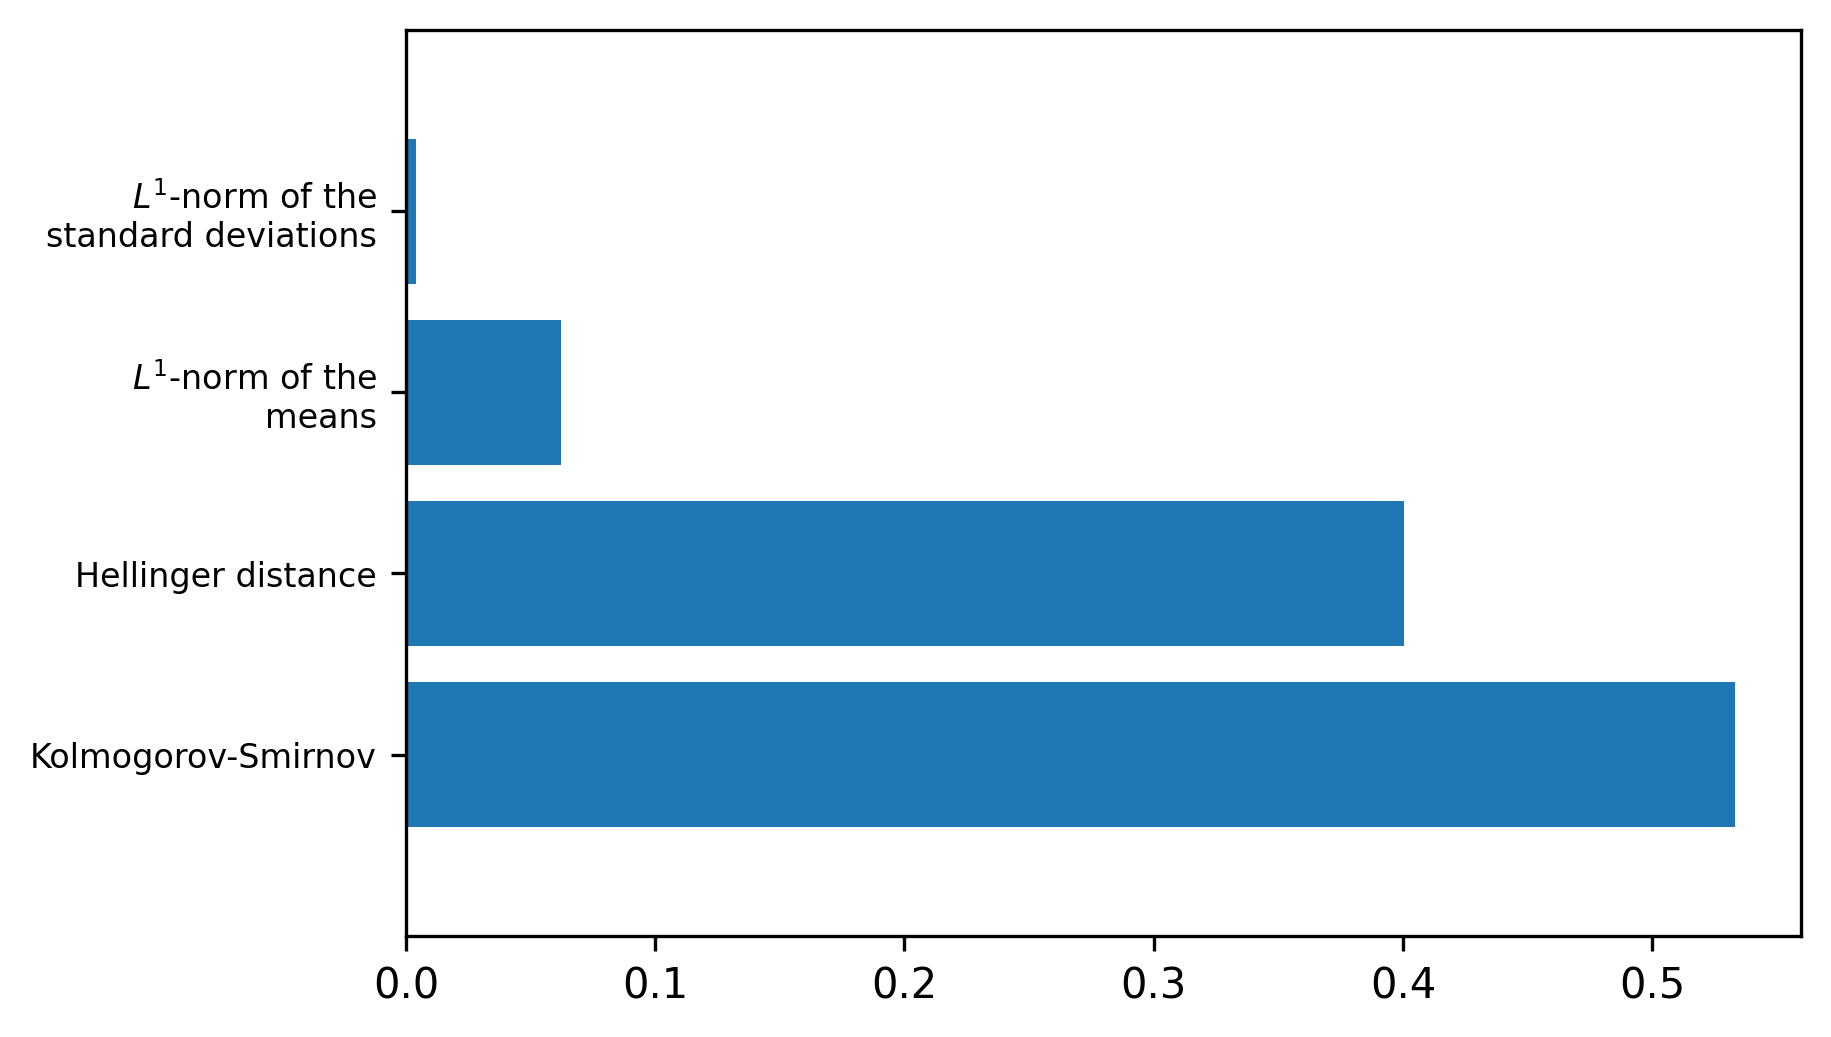

In [7]:
import matplotlib.pyplot as plt

f1 = [
    'mean',
    'std',
    'hellinger_distance',
    'ks_test',
]
features = f1
names = [
    '$L^1$-norm of the\nmeans',
    '$L^1$-norm of the\nstandard deviations',
    'Hellinger distance',
    'Kolmogorov-Smirnov',
]
forest = models['forest'].best_model.named_steps['forest']

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
results = list(zip(importances, std))
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i, index in enumerate(indices):
    print("%d. feature %s (%f)" % (i + 1, features[index], importances[index]))
print()
# Plot the impurity-based feature importances of the forest   
fig = plt.figure(dpi=300)
ax = fig.add_subplot()
fig.patch.set_facecolor('#FFFFFF')
ax.barh(
    range(len(features)),
    importances[indices],
    color="tab:blue",
    align="center"
)
ax.set_yticks(ticks=range(len(features)))
ax.set_yticklabels(labels=[names[i] for i in indices], ha='right', fontsize='8')
ax.set_ylim([-1, len(features)])

print(fig)
fig.savefig('feature_importance.png',bbox_inches = "tight")

In [8]:
from joblib import load
from dmatch.utils import Accessor
import pandas as pd

pd.set_option('display.max_colwidth', -1)
def get_name(row):
    eida, eidb = row.name
    eida = '{0}:../index/{1}'.format(*eida.split(':'))
    eidb = '{0}:../index/{1}'.format(*eidb.split(':'))
    resa = Accessor.get_entity_metadata(eida)
    resb = Accessor.get_entity_metadata(eidb)
    namea = ' | '.join(resa[['label', 'fluid', 'category', 'loinc']])
    nameb = ' | '.join(resb[['label', 'fluid', 'category', 'loinc']])
    return (namea, nameb)


df = TEST.copy()
model = models['forest'].best_model

df['predict'] = model.predict(TEST.drop('Y', axis=1))
df[['proba_false', 'proba_true']] = model.predict_proba(TEST.drop('Y', axis=1))
a = df[np.in1d(df.index.get_level_values('entityA'), ['51355:mimic3_test_A'])]
r = a.sort_values('proba_true', ascending=False)
res = pd.concat([r, r.apply(get_name, axis=1, result_type='expand')], axis=1).head(5)

res[[0, 1, 'Y', 'predict', 'proba_true']].reset_index()

/tmp/ipykernel_20272/1942270061.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,entityA,entityB,0,1,Y,predict,proba_true
0,51355:mimic3_test_A,51120:mimic3_test_B,Monocytes | Cerebrospinal Fluid (CSF) | Hematology | 26486-1,Monocytes | Ascites | Hematology | 26488-7,False,True,0.992
1,51355:mimic3_test_A,51355:mimic3_test_B,Monocytes | Cerebrospinal Fluid (CSF) | Hematology | 26486-1,Monocytes | Cerebrospinal Fluid (CSF) | Hematology | 26486-1,True,True,0.944
2,51355:mimic3_test_A,51352:mimic3_test_B,Monocytes | Cerebrospinal Fluid (CSF) | Hematology | 26486-1,Macrophage | Cerebrospinal Fluid (CSF) | Hematology | 30426-1,False,False,0.016
3,51355:mimic3_test_A,50801:mimic3_test_B,Monocytes | Cerebrospinal Fluid (CSF) | Hematology | 26486-1,Alveolar-arterial Gradient | Blood | Blood Gas | 19991-9,False,False,0.000
4,51355:mimic3_test_A,51130:mimic3_test_B,Monocytes | Cerebrospinal Fluid (CSF) | Hematology | 26486-1,Absolute CD3 Count | Blood | Hematology | 8124-0,False,False,0.000
